In [1]:
import sys 
sys.path.append('..')

In [2]:
import lib.utils as utils
import baseline.estimators as estimators
import nncf.run_model_test as nn_test
from nncf.evaluate_recall import evaluate_model_recall

import os
import pickle
import scipy.sparse as sp
from nncf.evaluate_recall import get_preds
from importlib import reload
import numpy as np
from sklearn.metrics import jaccard_score, recall_score
from importlib import reload
import seaborn as sns
import pandas as pd

Using TensorFlow backend.


In [3]:
PROJ_ROOT_DIR = os.path.join(os.path.abspath(''), '..')

In [4]:
reload(estimators)

<module 'baseline.estimators' from '../baseline/estimators.py'>

In [5]:
TEST_PART_SIZE = 2000
M_SPACE = np.linspace(10, 90, 3, dtype="int32")

# All data

### Load dataset:

In [6]:
test_set_path = os.path.join(PROJ_ROOT_DIR, "data", "test_tag_dataset.pkl")
with open(test_set_path, 'rb') as f:
    X, y, mlbx, mlby, val_y, test_y = pickle.load(f)
    y = y.tocsr()
    X = sp.csr_matrix(X)
    test_y = test_y.toarray()
NUM_USER_TAGS = y.shape[1]

### Load pretrained nn model and generate performance list:

In [6]:
nn_model_runfile_path = os.path.join(PROJ_ROOT_DIR, "nncf", "runs", "several_runs", "runu4.yml")

params = nn_test.read_params(nn_model_runfile_path)

nn_model = nn_test.build_model(params, y.shape, X.shape[1])

In [45]:
k_list_nn = [(*evaluate_model_recall(nn_model, y[:TEST_PART_SIZE], 
                                test_y, K, X[:TEST_PART_SIZE].toarray(), False), K, "nn")
          for K in M_SPACE
         ]

In [46]:
k_list_nn

[(0.3300602544074983, 0.11375173050299954, 10, 'nn'),
 (0.5282303057353269, 0.04541965690601374, 50, 'nn'),
 (0.6036598973443428, 0.029473936541143653, 90, 'nn')]

### Train base model and generate performance list

In [9]:
base_model = estimators.BaselineModel(factors=1000,
                                regularization=7,
                                iterations=15,
                                show_progress=False,
                                n=3,
                                content_scale_factor=0.0424,
                                alpha=2.17)

In [10]:
base_model.fit(X, y)

BaselineModel(alpha=2.17, content_scale_factor=0.0424, factors=1000,
              filter_seen=True, iterations=15, n=3, regularization=7,
              show_progress=False)

In [13]:
def compute_metrics(test_y, preds):
    return recall_score(test_y, preds, average='micro'), jaccard_score(test_y, preds, average='micro')

In [42]:
k_list_base = [
    (*compute_metrics(test_y, base_model.predict(X[:TEST_PART_SIZE], start_index=0, n=K)), K, "Base")
               for K in M_SPACE
]

In [43]:
k_list_base

[(0.3519303726846686, 0.1222101673899566, 10, 'base'),
 (0.5805623744699844, 0.05014504765851637, 50, 'base'),
 (0.6603436732872127, 0.032331024234610255, 90, 'base')]

### And the same for random preds

In [181]:
def generate_random_preds(shape, m):
    matrix = np.zeros(shape)
    for row in matrix:
        row[np.random.choice(shape[1], m, replace=False)] = 1
    return matrix

In [199]:
k_list_random = [
    (*compute_metrics(test_y, generate_random_preds((TEST_PART_SIZE, NUM_USERTAGS), K)), K, "Random")
               for K in M_SPACE
]

In [200]:
k_list_random

[(0.004463289444320465, 0.0013830302192102898, 10, 'Random'),
 (0.025552332068734657, 0.002106076352165396, 50, 'Random'),
 (0.046976121401472885, 0.002232936072260145, 90, 'Random')]

### Generate figures

In [201]:
df = pd.DataFrame(k_list_base + k_list_nn + k_list_random, columns=["Recall", "Jaccard", "M", "Type"])
df

,Recall,Jaccard,M,Type
0,0.351930,0.122210,10,base
1,0.580562,0.050145,50,base
2,0.660344,0.032331,90,base
3,0.330060,0.113752,10,nn
4,0.528230,0.045420,50,nn
5,0.603660,0.029474,90,nn
6,0.004463,0.001383,10,Random
7,0.025552,0.002106,50,Random
8,0.046976,0.002233,90,Random


In [202]:
sns.set_style("whitegrid")

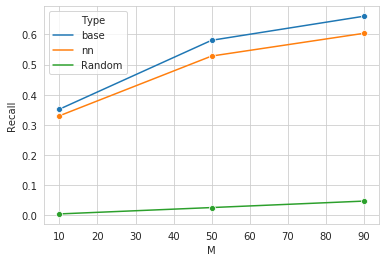

In [203]:
plot = sns.lineplot(x="M", y="Recall", marker="o", hue="Type", data=df)

In [ ]:
plot.figure.savefig("M_plot_nn_base.svg")

# Cold start

### Load dataset

In [ ]:
test_set_path = os.path.join(PROJ_ROOT_DIR, "data", "cold_0.0_test_tag_dataset.pkl")
with open(test_set_path, 'rb') as f:
    X, y, mlbx, mlby, val_y, test_y = pickle.load(f)
    y = y.tocsr()
    X = sp.csr_matrix(X)
    test_y = test_y.toarray()
NUM_USER_TAGS = y.shape[1]

Otherwise identical; do a function instead!

In [7]:
import sys 
sys.path.append('..')

In [8]:
import lib.utils as utils
import baseline.estimators as estimators
import nncf.run_model_test as nn_test
from nncf.evaluate_recall import evaluate_model_recall

import os
import pickle
import scipy.sparse as sp
import numpy as np
from sklearn.metrics import jaccard_score, recall_score
import seaborn as sns
import pandas as pd

In [9]:
def compute_metrics(test_y, preds):
    return recall_score(test_y, preds, average='micro'), jaccard_score(test_y, preds, average='micro')

In [10]:
def get_base_results(X, y, test_y, m_space):
    test_part_size = test_y.shape[0]
    
    base_model = estimators.BaselineModel(factors=1000,
                                        regularization=7,
                                        iterations=15,
                                        show_progress=False,
                                        n=3,
                                        content_scale_factor=0.0424,
                                        alpha=2.17)
    base_model.fit(X, y)
    
    k_list_base = [
        (*compute_metrics(test_y, base_model.predict(X[:test_part_size], start_index=0, n=K)), K, "Base")
        for K in m_space
    ]
    
    return k_list_base

In [21]:
def get_nn_results(X, y, test_y, proj_root_dir, config_file_path, m_space):
    test_part_size = test_y.shape[0]

    params = nn_test.read_params(config_file_path)

    nn_model = nn_test.build_model(params, y.shape, X.shape[1])
    
    k_list_nn = [
        (*evaluate_model_recall(nn_model, y[:test_part_size], 
                                test_y, K, X[:test_part_size].toarray(), False), K, "nn")
        for K in m_space
    ]
    
    return k_list_nn

In [12]:
def get_random_results(test_y, m_space, num_user_tags):
    np.random.seed(0)
    def generate_random_preds(shape, m):
        matrix = np.zeros(shape)
        for row in matrix:
            row[np.random.choice(shape[1], m, replace=False)] = 1
        return matrix
    k_list_random = [
        (*compute_metrics(test_y, generate_random_preds(test_y.shape, K)), K, "Random")
        for K in m_space
    ]
    
    return k_list_random

In [22]:
def produce_df_for_plot(m_space, proj_root_dir, dataset_file_name, nn_rel_path):
    test_set_path = os.path.join(proj_root_dir, "data", dataset_file_name)
    with open(test_set_path, 'rb') as f:
        X, y, mlbx, mlby, val_y, test_y = pickle.load(f)
        y = y.tocsr()
        X = sp.csr_matrix(X)
        test_y = test_y.toarray()
    num_user_tags = y.shape[1]

    nn_file_path = os.path.join(proj_root_dir, nn_rel_path)
    nn = get_nn_results(X, y, test_y, proj_root_dir, nn_file_path, m_space)

    base = get_base_results(X, y, test_y, m_space)
    random = get_random_results(test_y, m_space, num_user_tags)

    df = pd.DataFrame(nn + base + random, columns=["Recall", "Jaccard", "M", "Type"])
    return df

In [43]:
M_SPACE = np.linspace(10, 90, 3, dtype="int32")
PROJ_ROOT_DIR = os.path.join(os.path.abspath(''), '..')

In [12]:
sns.set_style("whitegrid")

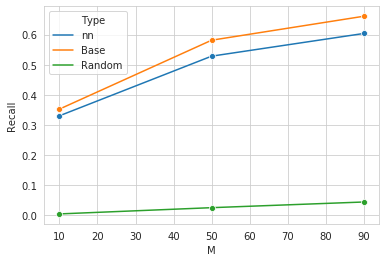

In [13]:
dataset_file_name = "test_tag_dataset.pkl"
nn_rel_path = os.path.join("nncf", "runs", "past_runs", "runu", "runu4.yml")
df = produce_df_for_plot(M_SPACE, PROJ_ROOT_DIR, dataset_file_name, nn_rel_path)
plot = sns.lineplot(x="M", y="Recall", marker="o", hue="Type", data=df)

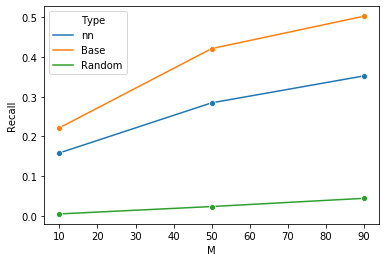

In [23]:
dataset_file_name = "cold_0.1_test_tag_dataset.pkl"
nn_rel_path = os.path.join("nncf", "runs", "past_runs", "runu", "runu8.yml")
df_cold_01 = produce_df_for_plot(M_SPACE, PROJ_ROOT_DIR, dataset_file_name, nn_rel_path)
plot01 = sns.lineplot(x="M", y="Recall", marker="o", hue="Type", data=df_cold_01)

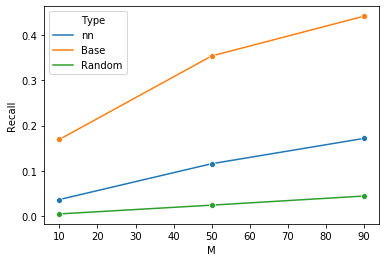

In [24]:
dataset_file_name = "cold_0.0_test_tag_dataset.pkl"
nn_rel_path = os.path.join("nncf", "runs", "past_runs", "runu", "runu11.yml")
df_cold_00 = produce_df_for_plot(M_SPACE, PROJ_ROOT_DIR, dataset_file_name, nn_rel_path)
plot00 = sns.lineplot(x="M", y="Recall", marker="o", hue="Type", data=df_cold_00)

In [ ]:
plot.figure.savefig("M_plot_nn_base.svg")

In [37]:
import os

In [46]:
proj_root_dir = PROJ_ROOT_DIR
dataset_file_name = ""
test_set_path = os.path.join(proj_root_dir, "data", "cold_0.0_test_tag_dataset.pkl")
with open(test_set_path, 'rb') as f:
    X, y, mlbx, mlby, val_y, test_y = pickle.load(f)
    y = y.tocsr()
    X = sp.csr_matrix(X)
    test_y = test_y.toarray()
num_user_tags = y.shape[1]


In [53]:
m_space = M_SPACE
nn_file_path = os.path.join(proj_root_dir, "nncf", "runs", "several_runs", "runu4.yml")
nn = get_nn_results(X, y, test_y, proj_root_dir, nn_file_path, m_space)


In [54]:
df = pd.DataFrame(nn, columns=["Recall", "Jaccard", "M", "Type"])

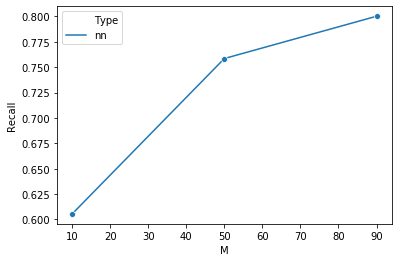

In [55]:
ploto = sns.lineplot(x="M", y="Recall", marker="o", hue="Type", data=df)

In [62]:
df

,Recall,Jaccard,M,Type
0,0.605434,0.404470,10,nn
1,0.758543,0.131853,50,nn
2,0.800209,0.079069,90,nn


In [ ]:

base = get_base_results(X, y, test_y, m_space)
random = get_random_results(test_y, m_space, num_user_tags)

df = pd.DataFrame(nn + base + random, columns=["Recall", "Jaccard", "M", "Type"])
return df

### Trams

In [8]:
1+1

2

In [34]:
david2 = 2

def david():
    tre = 2
    vari = 5
    def oliwer():
        global david2
        print(david2)
        david2 = 2
    oliwer()
#david()

def oliwer():
    global tre
    print(tre)
oliwer()

1
